# Preprocessing data

### Imports

In [1]:
import os
from preprocessors.edfpreprocessor import EDFPreprocessorAcc as edfaccpp
from preprocessors.edfpreprocessor import EDFPreprocessorECG as edfecgpp
from preprocessors.avropreprocessor import AvroAcc as avroaccpp
from preprocessors.oepreprocessor import OEPreprocessor as oepp
from preprocessors.concat_avro import AvroMerger
from sync.synchotron import synchotron
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
participant_id = "P05"

parentdir = "data"
path = os.path.join(parentdir, participant_id)

OELpath = os.path.join(path, "Pilot05L.oe")
OERpath = os.path.join(path, "Pilot05R.oe")
EDFpath = os.path.join(path, "P05.edf")
avro_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".avro"):
            avro_files.append(os.path.join(root, file))

merged_avro_output_path = os.path.join(path, f"{participant_id}_merged.avro")
if not os.path.exists(merged_avro_output_path):
    avromerger = AvroMerger(avro_files)
    avromerger.merge_avro_files(merged_avro_output_path)



In [3]:
oedataL = oepp(OELpath).load()
oedataR = oepp(OERpath).load()
edfaccdata = edfaccpp(EDFpath).load()
edfecgdata = edfecgpp(EDFpath).load()
avroaccdata = avroaccpp(merged_avro_output_path).load()
print("Data loaded successfully.")

📂 File: Pilot05L.oe, Version: 1, Timestamp: 1970-10-23 18:59:55
📂 File: Pilot05R.oe, Version: 1, Timestamp: 1971-06-13 05:09:45
read -1, less than 553600 requested!!!
read -1, less than 553600 requested!!!
Data loaded successfully.


Calculated sample rate: 64.0067672737931 Hz
Calculated sample rate: 100.0 Hz
Calculated sample rate: 49.951214643527884 Hz
Calculated sample rate: 49.951024559498585 Hz
Extracted window from index 5095 to 5415 (1s before and 4s after first 95% max point)
                    datetime  abs_mag_z
0 2025-10-23 14:41:31.477781   1.573627
1 2025-10-23 14:41:31.493404   0.934564
2 2025-10-23 14:41:31.509028   0.666538
3 2025-10-23 14:41:31.524651   0.662457
4 2025-10-23 14:41:31.540274   0.655929
5 2025-10-23 14:41:31.555898   0.380558
6 2025-10-23 14:41:31.571521   1.389089
7 2025-10-23 14:41:31.587144   0.744059
8 2025-10-23 14:41:31.602768   1.045593
9 2025-10-23 14:41:31.618391   0.607809
Extracted window from index 552395 to 552895 (1s before and 4s after first 95% max point)
                 datetime  abs_mag_z
0 2025-10-23 16:13:58.950   8.246226
1 2025-10-23 16:13:58.960   8.081188
2 2025-10-23 16:13:58.970   8.246226
3 2025-10-23 16:13:58.980   8.397511
4 2025-10-23 16:13:58.990   8.

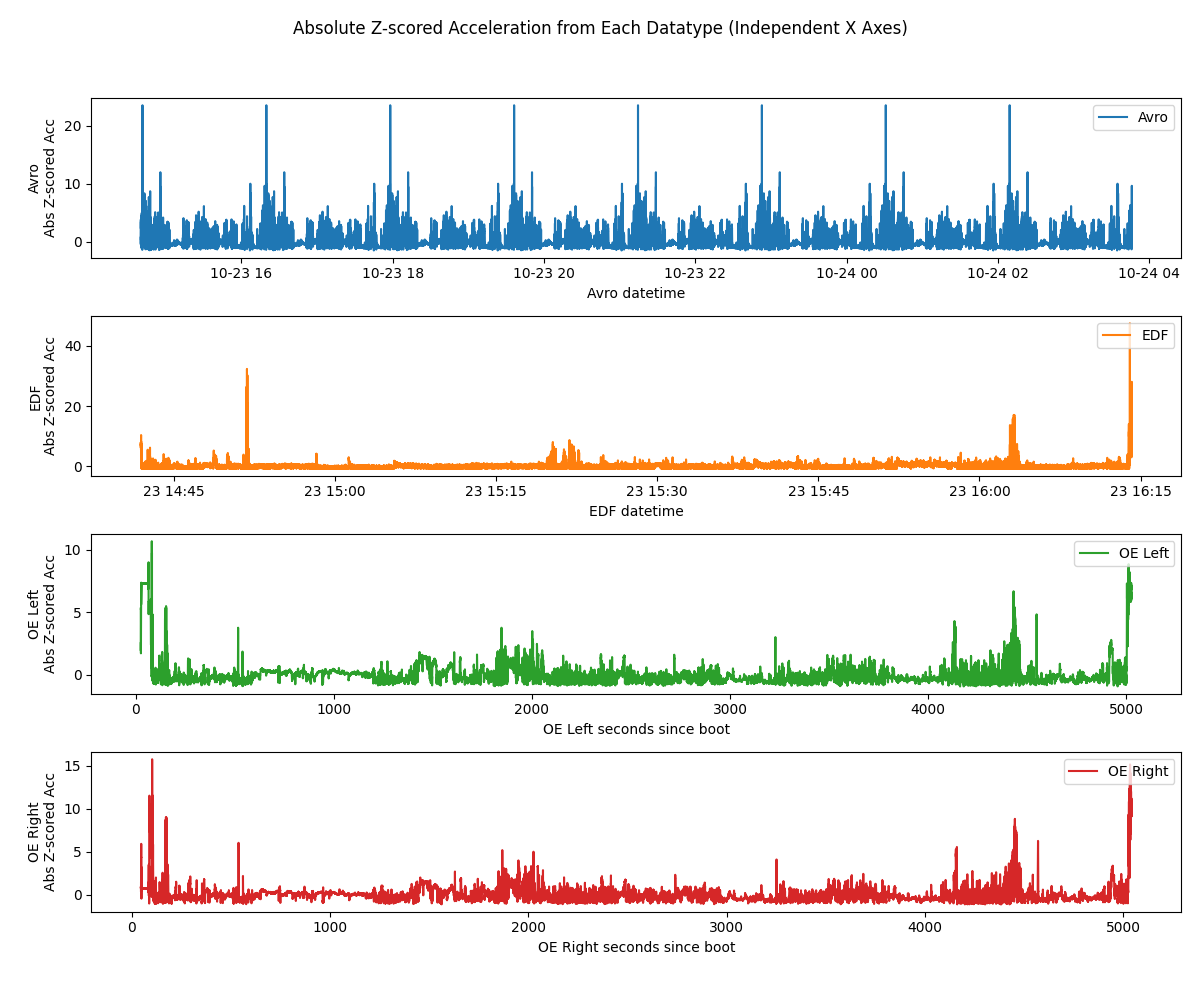

In [6]:
# syncing data

syncer = synchotron(
    avroaccdata,
    edfaccdata,
    oedataL,
    oedataR,
)
syncer.plot_unsynced()




Use this plot and inspect to find the time ranges to search for for the jumps, and then provide this to the synchronisation function.
Matplotlib has been configured in this notebook so that there is a tool in the tab on the left, 'zoom to rectangle' 

In [ ]:
edf_start_datetime = "2024-10-23 14:51:43"
edf_end_datetime = "2024-10-23 14:51:52"

avrowindow = (1500, 2500)  
oeLwindow = (1500, 2500)  
oeRwindow = (1500, 2500) 
 
syncer.plot_windowed()

avro_shift, oeL_shift, oeR_shift = syncer.sync()